In [1]:
#IMPORTING DATASET
import pandas as pd
data=pd.read_csv("Inconel825.csv")
data.head()

,Ton,Toff,Current,Ra,Mrr
0,20,10,5,3.08,5.76
1,20,10,1,2.21,1.11
2,50,10,3,3.46,4.77
3,80,10,1,4.26,1.32
4,50,15,5,4.05,5.48


In [2]:
# FOR GRAPHS
import matplotlib.pyplot as plt  #LIBRARY
import seaborn as sns           #LIBRARY

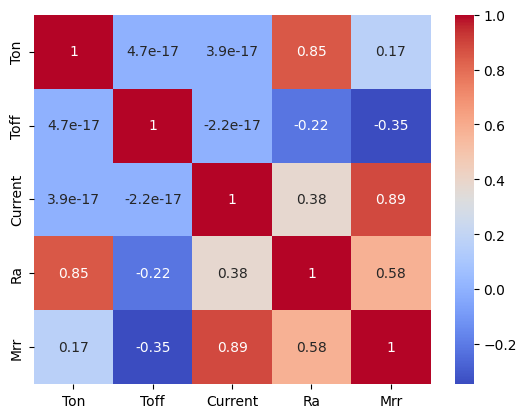

In [3]:
# FINDING CORELATION BETWEEN FEATURES
a=data.corr()
sns.heatmap(a, annot=True, cmap="coolwarm")
plt.show()

In [4]:
data.drop(columns=["Mrr"], inplace=True)

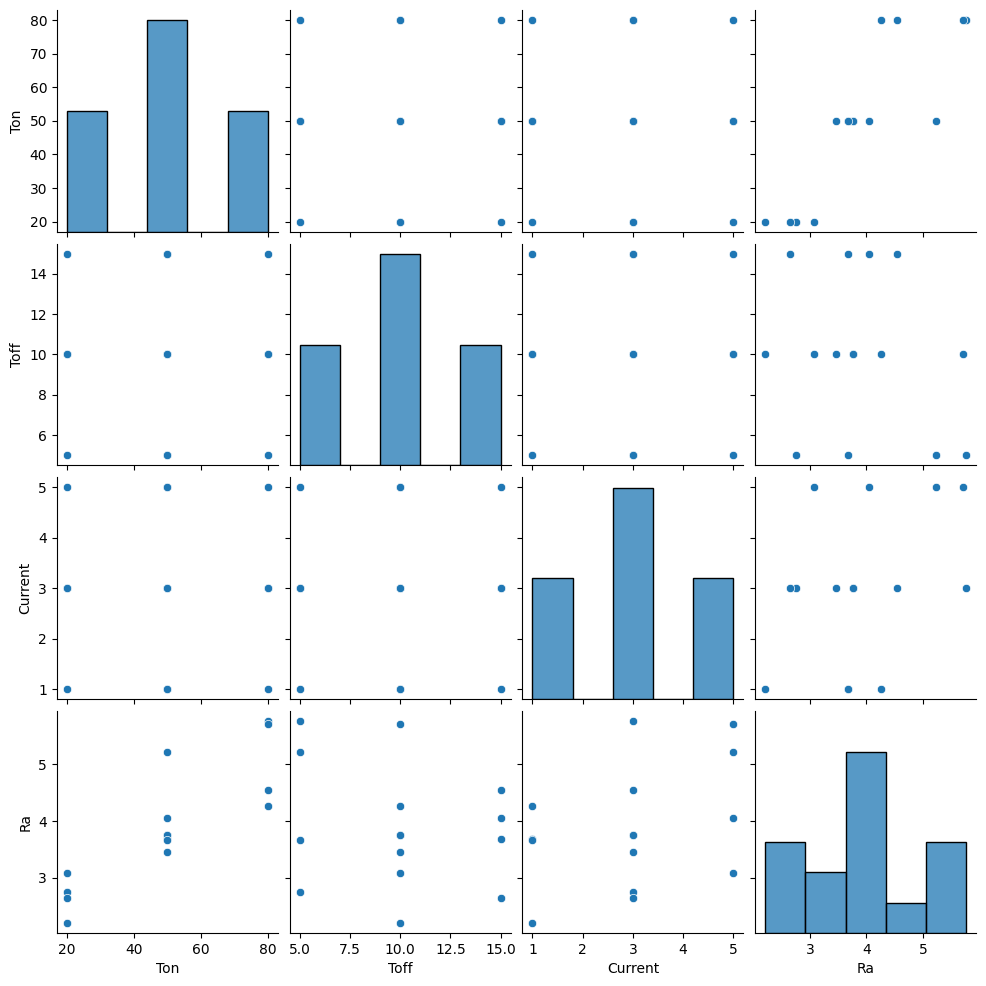

In [5]:
#MAKING PAIR PLOT FOR COMPARISON AND FINDING DEGREE OF RELATION
sns.pairplot(data=data)
plt.show()

In [6]:
# REQUIRED LIBRARIES
from sklearn.model_selection import train_test_split #FOR DIVIDING DATA INTO TRAIN AND TEST
from sklearn.preprocessing import PolynomialFeatures, StandardScaler  # FOR FEATURE SCALING AND DECIDING DEGREE OF POLYNOMIAL
from sklearn.linear_model import LinearRegression    #FOR TRAINING MODEL
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  #FOR CALCULATING ACCURACY AND ERROR OR FOR EVALUATE THE TRAINED MODEL
import numpy as np
import optuna

In [12]:
# ========== Step 1: Prepare Data ==========
# Assuming your DataFrame is called data1
x = data.drop(columns=["Ra"])
y = data["Ra"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# ========== Step 2: Polynomial Regression ==========
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_poly)
x_test_scaled = scaler.transform(x_test_poly)

model = LinearRegression()
model.fit(x_train_scaled, y_train)

# Predictions and Evaluation
y_pred_train = model.predict(x_train_scaled)
y_pred_test = model.predict(x_test_scaled)

metrics = {
    'Train': {
        'MSE': mean_squared_error(y_train, y_pred_train),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'R²': r2_score(y_train, y_pred_train)
    },
    'Test': {
        'MSE': mean_squared_error(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'R²': r2_score(y_test, y_pred_test)
    }
}

# Display results
print("┌──────────────────┬────────────┬────────────┬────────────┐")
print("│      Dataset     │    MSE     │    RMSE    │     R²     │")
print("├──────────────────┼────────────┼────────────┼────────────┤")
for dataset, values in metrics.items():
    print(f"│ {dataset:<16} │ {values['MSE']:>10.4f} │ {values['RMSE']:>10.4f} │ {values['R²']:>10.4f} │")
print("└──────────────────┴────────────┴────────────┴────────────┘")

# ========== Step 3: Bayesian Optimization (MINIMIZE Ra) ==========

# Define parameter bounds (customize if needed)
param_bounds = {
    col: (x_train[col].min(), x_train[col].max())
    for col in x_train.columns
}
param_bounds["Ton"] = (20, 80)      # µs
param_bounds["Toff"] = (5, 15)      # µs
param_bounds["Current"] = (1, 5)    # A

feature_order = list(x_train.columns)

# Objective function for Optuna to minimize Surface Roughness
def objective(trial):
    candidate = {
        feat: trial.suggest_float(feat, low, high)
        for feat, (low, high) in param_bounds.items()
    }

    X_new = pd.DataFrame([candidate])[feature_order]
    X_new_poly = poly.transform(X_new)
    X_new_scaled = scaler.transform(X_new_poly)
    ra_pred = model.predict(X_new_scaled)[0]

    return ra_pred  # We want to MINIMIZE Ra

# Run Bayesian Optimization (minimize Ra)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# Best Result
best_params = study.best_trial.params
best_ra = study.best_value

print("\n================ OPTIMISATION RESULT FOR Ra ================")
for k, v in best_params.items():
    print(f"{k:10s}: {v:.3f}")
print(f"Predicted Minimum Ra : {best_ra:.4f} µm")


[I 2025-07-17 20:25:00,482] A new study created in memory with name: no-name-cb4b205f-b100-4989-bae7-ab5c7ec891ce


┌──────────────────┬────────────┬────────────┬────────────┐
│      Dataset     │    MSE     │    RMSE    │     R²     │
├──────────────────┼────────────┼────────────┼────────────┤
│ Train            │     0.0041 │     0.0640 │     0.9962 │
│ Test             │     0.0573 │     0.2393 │     0.9416 │
└──────────────────┴────────────┴────────────┴────────────┘


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-07-17 20:25:00,501] Trial 0 finished with value: 2.951840905121621 and parameters: {'Ton': 37.51383799886515, 'Toff': 11.698737610305319, 'Current': 1.64057253431287}. Best is trial 0 with value: 2.951840905121621.
[I 2025-07-17 20:25:00,508] Trial 1 finished with value: 4.720217629919803 and parameters: {'Ton': 60.88096850131247, 'Toff': 8.066732543580331, 'Current': 4.256640703877981}. Best is trial 0 with value: 2.951840905121621.
[I 2025-07-17 20:25:00,518] Trial 2 finished with value: 3.0517187015878755 and parameters: {'Ton': 33.77157765481236, 'Toff': 8.862644987096505, 'Current': 3.3446947348771996}. Best is trial 0 with value: 2.951840905121621.
[I 2025-07-17 20:25:00,523] Trial 3 finished with value: 3.7340720702833514 and parameters: {'Ton': 50.36573732115565, 'Toff': 6.795420775738594, 'Current': 1.9307684195911348}. Best is trial 0 with value: 2.951840905121621.
[I 2025-07-17 20:25:00,532] Trial 4 finished with value: 4.2635020938387225 and parameters: {'Ton': 69.2

In [13]:
# regression equation
feature_names = poly.get_feature_names_out(input_features=['Ton', 'Toff', 'Current'])
# Show the equation
terms = [f"{coef:.4f}*{name}" for coef, name in zip(model.coef_, feature_names)]
equation = " + ".join(terms) + f" + {model.intercept_:.4f}"
print("Regression Equation:")
print(f"y = {equation}")

Regression Equation:
y = 1.3491*Ton + -0.9121*Toff + 0.0763*Current + -0.2574*Ton^2 + -0.5800*Ton Toff + 0.2901*Ton Current + 1.3558*Toff^2 + -0.4835*Toff Current + 0.3336*Current^2 + 3.8491


In [21]:
# FOR ADJUSTED R2 VALUE
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

adj_r2 = adjusted_r2(r2_score(y_train, y_pred_train), n=len(y_train), p=x_train.shape[1])
print("Adjusted R²:", adj_r2)

Adjusted R²: 0.994523231236037


In [15]:
# FOR CROSS-VALIDATION SCORE
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x, y, scoring='r2', cv=3)
print("Cross-Validation R² scores for Ra: ", scores)
print("Mean Cross-Validation R²:", scores.mean())

Cross-Validation R² scores for Ra:  [0.78852779 0.79820663 0.84157262]
Mean Cross-Validation R²: 0.8094356792610102


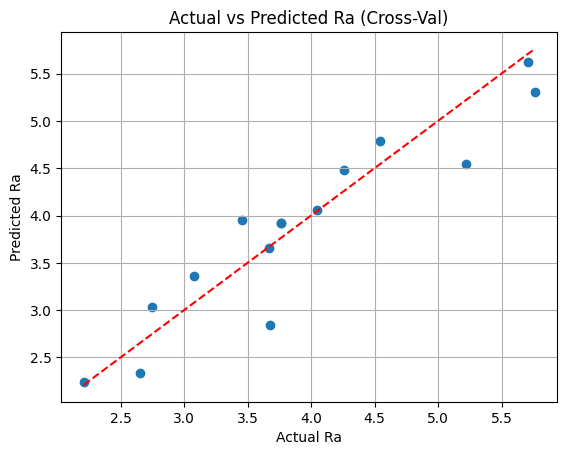

In [16]:
#GRAPGH FOR CROSS VALIDATION SCORE BETWEEN ACTUAL AND PRIDCTION 
from sklearn.model_selection import cross_val_predict
y_pred_cv = cross_val_predict(model, x, y, cv=5)
plt.scatter(y, y_pred_cv)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Ra")
plt.ylabel("Predicted Ra")
plt.title("Actual vs Predicted Ra (Cross-Val)")
plt.grid(True)
plt.show()

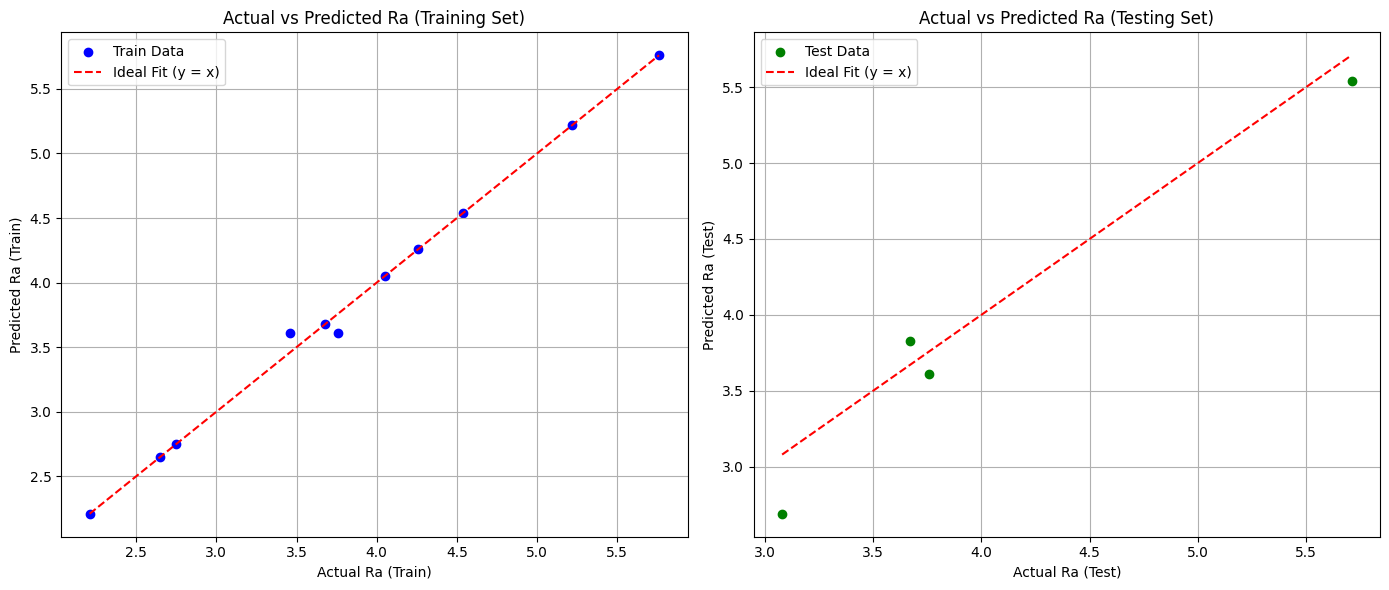

In [17]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, color='blue', label='Train Data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', label='Ideal Fit (y = x)')
plt.xlabel('Actual Ra (Train)')
plt.ylabel('Predicted Ra (Train)')
plt.title('Actual vs Predicted Ra (Training Set)')
plt.legend()
plt.grid(True)

# Step 6: Plot Actual vs. Predicted for Test Set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, color='green', label='Test Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit (y = x)')
plt.xlabel('Actual Ra (Test)')
plt.ylabel('Predicted Ra (Test)')
plt.title('Actual vs Predicted Ra (Testing Set)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Model Performance on Test Set:
Mean Squared Error (MSE): 0.0573
Mean Absolute Error (MAE): 0.2175
R² Score: 0.9416


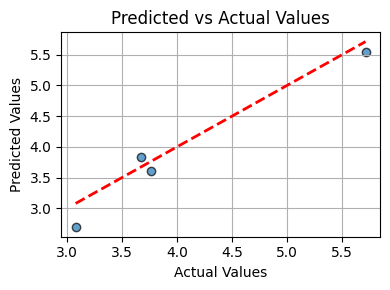

In [18]:
# GRAPH BETWEEN ACTUAL AND PREDICTED VALUES
# === 1. Predict on test data ===
y_pred_test = model.predict(x_test_scaled)
# === 2. Performance Metrics ===
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# === 3. Predicted vs Actual Plot ===
plt.figure(figsize=(4, 3))
plt.scatter(y_test, y_pred_test, edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#COMPARISON WITH OTHER METHODS OF MODEL TRAINING

In [62]:
# RANDOM FOREST FOR Ra:
from sklearn.ensemble import RandomForestRegressor# Required library

rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 0.5867661425000009
R2 Score: 0.2733366244365174


In [73]:
# DECISION TREE FOR Ra:
from sklearn.tree import DecisionTreeRegressor  # Required library

model_rad = DecisionTreeRegressor(random_state=0)
model_rad.fit(x_train, y_train)
y_pred = model_rad.predict(x_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 0.9282600000000001
R2 Score: -0.14957646009808312


In [67]:
# RIDGE REGRESSOR FOR Ra:
from sklearn.linear_model import RidgeCV  # Required library

ridge_ra= RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
ridge_ra.fit(x_train, y_train)
print("Ridge R²: ", ridge_ra.score(x_test, y_test))
y_pre=ridge_ra.predict(x_test)
mse = mean_squared_error(y_test, y_pre)
print("Mean Squared Error: ",mse)

Ridge R²:  0.782017319306687
Mean Squared Error:  0.1760166550062363
